In [24]:
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import os

In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\valse\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOGL', 'MSFT']

In [27]:
#actually getting the data from the website
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table



In [28]:
news_tables['MSFT']

<table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
<tr><td align="right" width="130">Apr-24-23 09:23PM</td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/time-buy-amazon-microsoft-stock-012301320.html" onclick="trackAndOpenNews(event, 'Zacks', 'https://finance.yahoo.com/news/time-buy-amazon-microsoft-stock-012301320.html');" rel="nofollow" target="_blank">Time to Buy Amazon or Microsoft Stock with Earnings Approaching?</a></div><div class="news-link-right"><span>(Zacks)</span></div></div></td></tr>
<tr><td align="right" width="130">08:00PM</td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/video/alphabet-microsoft-earnings-expect-call-000018466.html" onclick="trackAndOpenNews(event, 'Yahoo Finance Video', 'https://finance.yahoo.com/video/alphabet-micro

In [29]:
# Filtering based time and date
parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):

        if(row.a == None):
            continue
            
        titles = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, titles])

In [30]:
news = pd.DataFrame(parsed_data, columns=['Ticker', 'Date', 'Time', 'Titles']) #creating a dataframe
news['Date'] = pd.to_datetime(news['Date']).dt.date
news['Time'] = pd.to_datetime(news['Time']).dt.time
news.head()

,Ticker,Date,Time,Titles
0,AMZN,2023-04-24,21:23:00,Time to Buy Amazon or Microsoft Stock with Ear...
1,AMZN,2023-04-24,18:59:00,Amazon Faces Backlash Over One Of Its Budget Cuts
2,AMZN,2023-04-24,18:18:00,Big Tech Earnings Are Coming. What to Know Abo...
3,AMZN,2023-04-24,17:53:00,Amazon Contract Drivers in California Join Tea...
4,AMZN,2023-04-24,17:31:00,Bed Bath & Beyond bankruptcy I dont think any...


In [31]:
type(news['Time'][0])

datetime.time

In [32]:
type(news['Date'][0])

datetime.date

In [33]:
vader = SentimentIntensityAnalyzer()

In [34]:
scores = news['Titles'].apply(vader.polarity_scores)

In [35]:
scores.head()

0    {'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp...
1    {'neg': 0.202, 'neu': 0.642, 'pos': 0.156, 'co...
2    {'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...
3    {'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'comp...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: Titles, dtype: object

In [36]:
scores_df = pd.DataFrame.from_records(scores)
scores_df.head()

,neg,neu,pos,compound
0,0.000,0.841,0.159,0.1779
1,0.202,0.642,0.156,-0.1280
2,0.000,0.884,0.116,0.1779
3,0.000,0.606,0.394,0.4404
4,0.000,1.000,0.000,0.0000


In [37]:
scored_news = news.join(scores_df)
scored_news.head()

,Ticker,Date,Time,Titles,neg,neu,pos,compound
0,AMZN,2023-04-24,21:23:00,Time to Buy Amazon or Microsoft Stock with Ear...,0.000,0.841,0.159,0.1779
1,AMZN,2023-04-24,18:59:00,Amazon Faces Backlash Over One Of Its Budget Cuts,0.202,0.642,0.156,-0.1280
2,AMZN,2023-04-24,18:18:00,Big Tech Earnings Are Coming. What to Know Abo...,0.000,0.884,0.116,0.1779
3,AMZN,2023-04-24,17:53:00,Amazon Contract Drivers in California Join Tea...,0.000,0.606,0.394,0.4404
4,AMZN,2023-04-24,17:31:00,Bed Bath & Beyond bankruptcy I dont think any...,0.000,1.000,0.000,0.0000


In [39]:
scored_news.to_csv('my_data.csv')

C:\Users\valse\AppData\Local\Temp\ipykernel_19752\4277117094.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_c = scored_news.groupby(['Date', 'Ticker']).mean()


<AxesSubplot: xlabel='Date'>

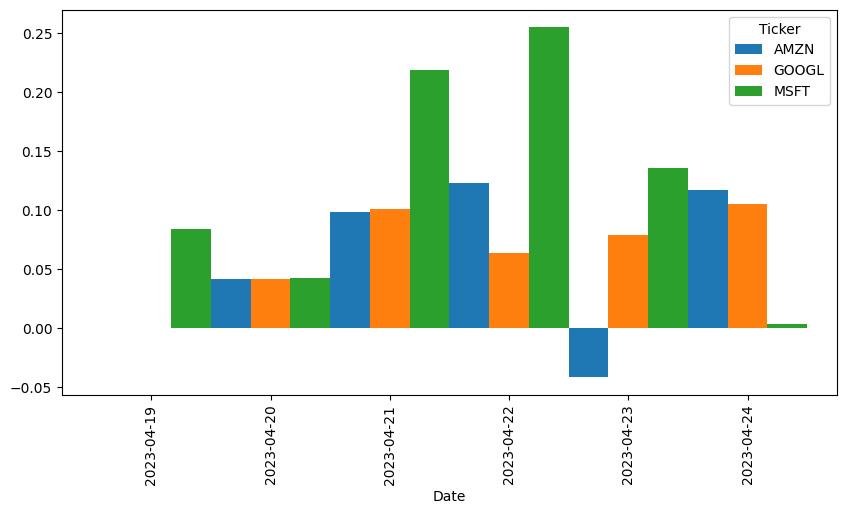

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['Date', 'Ticker']).mean()

# Unstack the column ticker
mean_c = mean_c.unstack('Ticker')

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
# Plot a bar chart with pandas

mean_c.plot(kind='bar', figsize=(10,5), width=1)

In [55]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task("Covid cases are increasing fast!")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'negative', 'score': 0.7235764861106873}]

In [56]:
example = "today is a bad day"
sentiment_task(example)

[{'label': 'negative', 'score': 0.9077997207641602}]

In [44]:
scored_news['roberta_sent'] = scored_news['Titles'].apply(lambda x: sentiment_task(x)[0]['label'])

In [45]:
scored_news['roberta_score'] = scored_news['Titles'].apply(lambda x: sentiment_task(x)[0]['score'])

In [46]:
scored_news.head()

,Ticker,Date,Time,Titles,neg,neu,pos,compound,roberta_sent,roberta_score
0,AMZN,2023-04-24,21:23:00,Time to Buy Amazon or Microsoft Stock with Ear...,0.000,0.841,0.159,0.1779,neutral,0.837170
1,AMZN,2023-04-24,18:59:00,Amazon Faces Backlash Over One Of Its Budget Cuts,0.202,0.642,0.156,-0.1280,negative,0.664012
2,AMZN,2023-04-24,18:18:00,Big Tech Earnings Are Coming. What to Know Abo...,0.000,0.884,0.116,0.1779,positive,0.885629
3,AMZN,2023-04-24,17:53:00,Amazon Contract Drivers in California Join Tea...,0.000,0.606,0.394,0.4404,neutral,0.839517
4,AMZN,2023-04-24,17:31:00,Bed Bath & Beyond bankruptcy I dont think any...,0.000,1.000,0.000,0.0000,negative,0.574536


In [58]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

credential = AzureKeyCredential("you_need_to_request_for_the_key")
client = TextAnalyticsClient(endpoint="https://text-sent-720.cognitiveservices.azure.com/", credential=credential)

In [59]:
sentence = 'Room was clean, but staff was rude.'

res = client.analyze_sentiment(documents=[sentence])

In [60]:
print('Scores : {}'.format(res[0]))

Scores : {'id': '0', 'sentiment': 'negative', 'warnings': [], 'statistics': None, 'confidence_scores': SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0), 'sentences': [SentenceSentiment(text=Room was clean, but staff was rude., sentiment=negative, confidence_scores=SentimentConfidenceScores(positive=0.0, neutral=0.0, negative=1.0), length=35, offset=0, mined_opinions=[])], 'detected_language': None, 'is_error': False, 'kind': 'SentimentAnalysis'}


In [61]:
client.close()

In [ ]:
from torch.nn import functional as F
import torch

In [178]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [107]:
encoded_text  = tokenizer('Today is a best day', return_tensors = "pt")

In [108]:
output = model(**encoded_text)

In [109]:
softmax(output[0][0].detach().numpy()) # the first element is the negative score second is neutral and third is positive

array([0.00165589, 0.00757926, 0.99076486], dtype=float32)

In [103]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [104]:
sentiment_scores = scored_news['Titles'].apply(polarity_scores_roberta)

In [105]:
# Create new columns for the sentiment scores
scored_news['rob_positive'] = sentiment_scores.apply(lambda x: x['roberta_pos'])
scored_news['rob_negative'] = sentiment_scores.apply(lambda x: x['roberta_neg'])
scored_news['rob_neutral'] = sentiment_scores.apply(lambda x: x['roberta_neu'])

In [106]:
scored_news.head()

,Ticker,Date,Time,Titles,neg,neu,pos,compound,roberta_sent,roberta_score,rob_positive,rob_negative,rob_neutral
0,AMZN,2023-04-24,21:23:00,Time to Buy Amazon or Microsoft Stock with Ear...,0.000,0.841,0.159,0.1779,neutral,0.837170,0.163798,0.015856,0.820346
1,AMZN,2023-04-24,18:59:00,Amazon Faces Backlash Over One Of Its Budget Cuts,0.202,0.642,0.156,-0.1280,negative,0.664012,0.014129,0.711761,0.274110
2,AMZN,2023-04-24,18:18:00,Big Tech Earnings Are Coming. What to Know Abo...,0.000,0.884,0.116,0.1779,positive,0.885629,0.841672,0.002017,0.156311
3,AMZN,2023-04-24,17:53:00,Amazon Contract Drivers in California Join Tea...,0.000,0.606,0.394,0.4404,neutral,0.839517,0.120215,0.046438,0.833347
4,AMZN,2023-04-24,17:31:00,Bed Bath & Beyond bankruptcy I dont think any...,0.000,1.000,0.000,0.0000,negative,0.574536,0.074957,0.535777,0.389266


In [110]:
scored_news['date_time'] = pd.to_datetime(scored_news['Date'].astype(str) + ' ' + scored_news['Time'].astype(str))

In [113]:
scored_news.head()

,Ticker,Date,Time,Titles,neg,neu,pos,compound,roberta_sent,roberta_score,rob_positive,rob_negative,rob_neutral,date_time
0,AMZN,2023-04-24,21:23:00,Time to Buy Amazon or Microsoft Stock with Ear...,0.000,0.841,0.159,0.1779,neutral,0.837170,0.163798,0.015856,0.820346,2023-04-24 21:23:00
1,AMZN,2023-04-24,18:59:00,Amazon Faces Backlash Over One Of Its Budget Cuts,0.202,0.642,0.156,-0.1280,negative,0.664012,0.014129,0.711761,0.274110,2023-04-24 18:59:00
2,AMZN,2023-04-24,18:18:00,Big Tech Earnings Are Coming. What to Know Abo...,0.000,0.884,0.116,0.1779,positive,0.885629,0.841672,0.002017,0.156311,2023-04-24 18:18:00
3,AMZN,2023-04-24,17:53:00,Amazon Contract Drivers in California Join Tea...,0.000,0.606,0.394,0.4404,neutral,0.839517,0.120215,0.046438,0.833347,2023-04-24 17:53:00
4,AMZN,2023-04-24,17:31:00,Bed Bath & Beyond bankruptcy I dont think any...,0.000,1.000,0.000,0.0000,negative,0.574536,0.074957,0.535777,0.389266,2023-04-24 17:31:00


In [119]:
new_df = scored_news[scored_news['Date'] >= pd.Timestamp('2023-04-20')]

C:\Users\valse\AppData\Local\Temp\ipykernel_19752\392676643.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  new_df = scored_news[scored_news['Date'] >= pd.Timestamp('2023-04-20')]


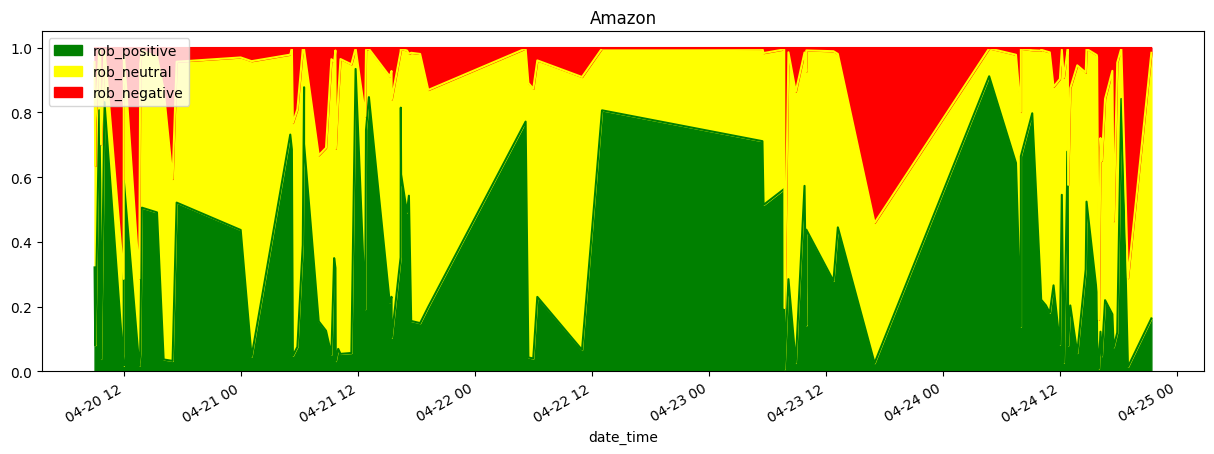

In [135]:

colors = {'rob_positive':'green', 'rob_negative':'red', 'rob_neutral':'yellow'}
new_df[new_df['Ticker'] == 'AMZN'].plot.area(x='date_time', y=['rob_positive', 'rob_neutral','rob_negative' ], figsize=(15,5), title='Amazon', color = colors)
plt.legend(loc='upper left')

In [161]:
import yfinance as yf

# get data for a specific ticker between two dates
ticker = "AMZN"
start_date = "2023-04-20"
end_date = "2023-04-25"
data = yf.download(ticker, start=start_date, end=end_date, interval = '5m')



[*********************100%***********************]  1 of 1 completed


<AxesSubplot: title={'center': 'Amazon'}, xlabel='Datetime'>

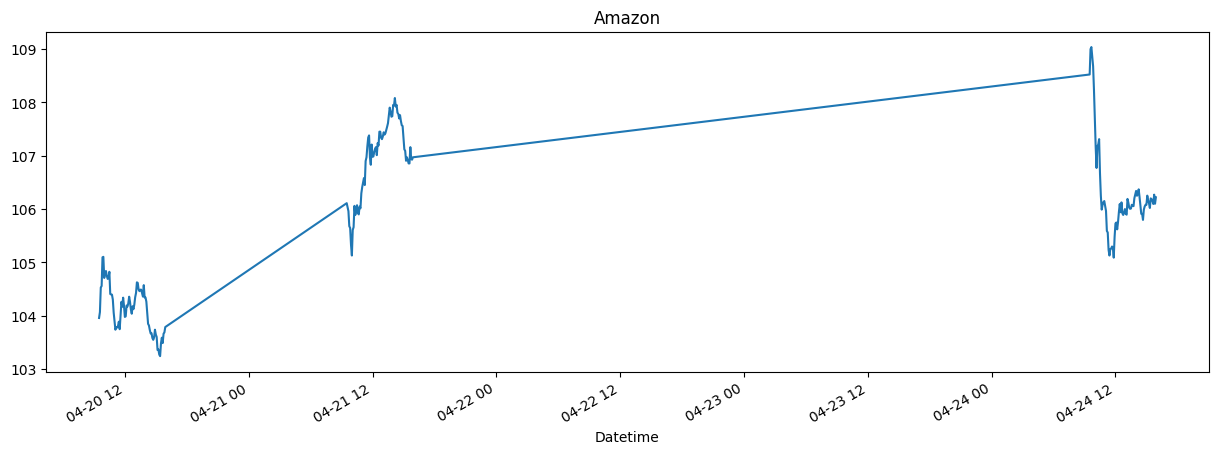

In [162]:
data['Close'].plot(figsize=(15,5), title='Amazon')

In [159]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-04-21 13:30:00-04:00,107.541901,108.150002,107.519997,107.805603,107.805603,10547317
2023-04-21 14:30:00-04:00,107.809998,107.900002,106.839996,106.919998,106.919998,9161720
2023-04-21 15:30:00-04:00,106.930000,107.209999,106.750000,106.970001,106.970001,7747244
2023-04-24 09:30:00-04:00,107.654999,109.230003,106.620003,107.309898,107.309898,23878631
2023-04-24 10:30:00-04:00,107.307297,107.349998,105.089996,105.129997,105.129997,11660602
2023-04-24 11:30:00-04:00,105.120003,106.099998,105.070000,106.095001,106.095001,8419039
2023-04-24 12:30:00-04:00,106.091599,106.250000,105.730003,106.004997,106.004997,5162717
2023-04-24 13:30:00-04:00,106.010002,106.529999,105.959999,106.061401,106.061401,5178436
2023-04-24 14:30:00-04:00,106.070000,106.310097,105.675003,106.199997,106.199997,5446532


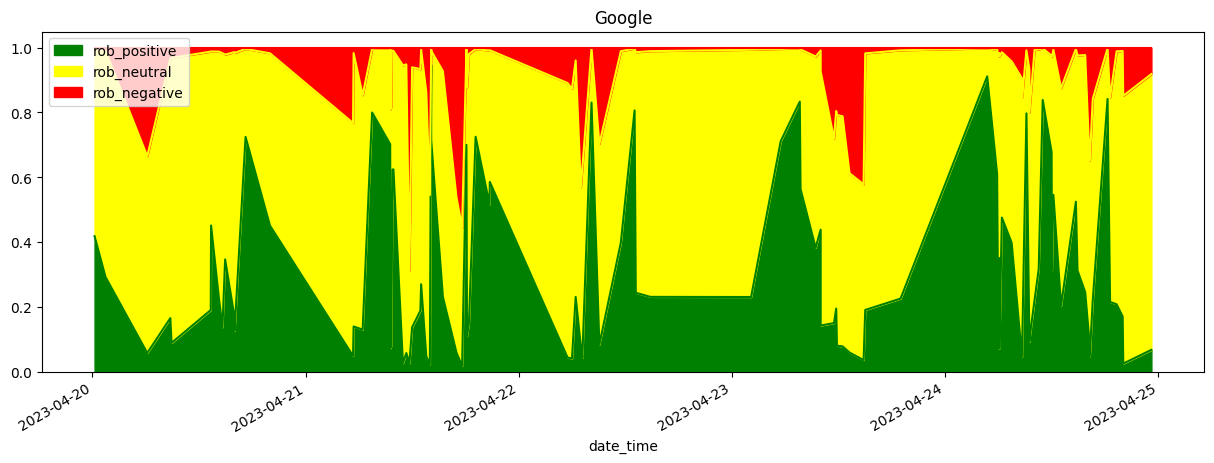

In [160]:
new_df[new_df['Ticker'] == 'GOOGL'].plot.area(x='date_time', y=['rob_positive', 'rob_neutral','rob_negative' ], figsize=(15,5), title='Google', color = colors)
plt.legend(loc='upper left')

In [163]:
ticker = "GOOGL"
start_date = "2023-04-20"
end_date = "2023-04-25"
data1 = yf.download(ticker, start=start_date, end=end_date, interval = '5m')


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: title={'center': 'Google'}, xlabel='Datetime'>

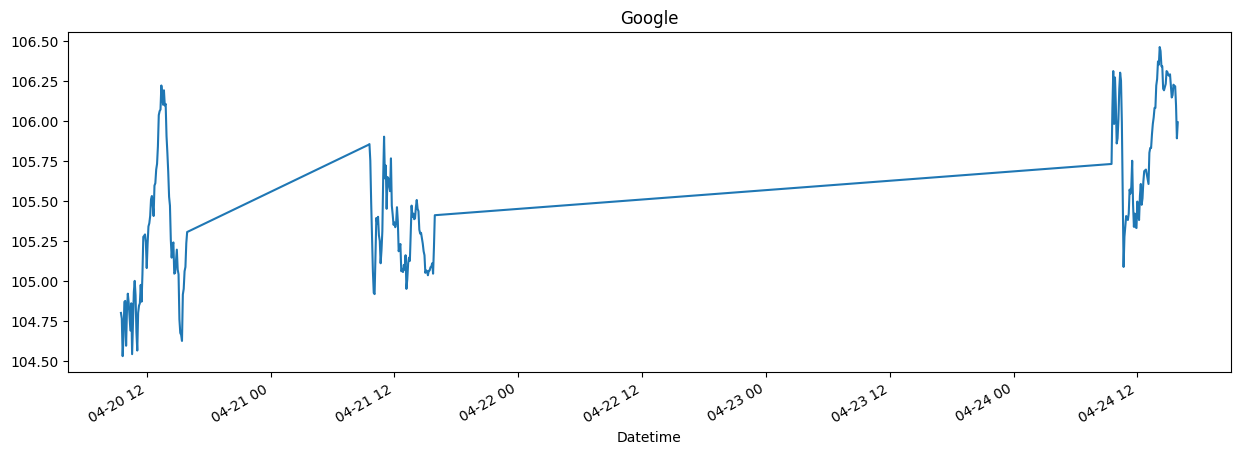

In [164]:
data1['Close'].plot(figsize=(15,5), title='Google')

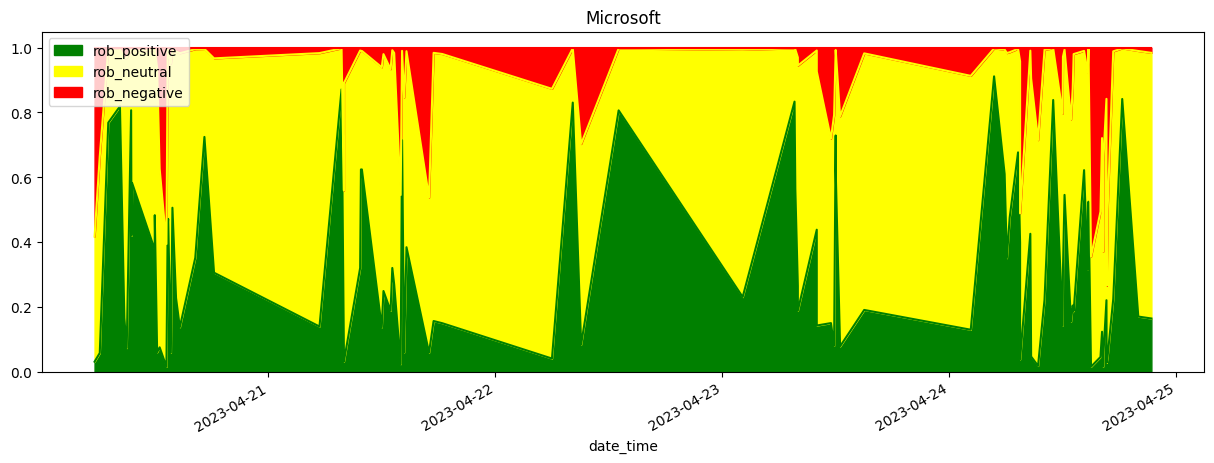

In [165]:
new_df[new_df['Ticker'] == 'MSFT'].plot.area(x='date_time', y=['rob_positive', 'rob_neutral','rob_negative' ], figsize=(15,5), title='Microsoft', color = colors)
plt.legend(loc='upper left')

In [166]:
ticker = "MSFT"
start_date = "2023-04-20"
end_date = "2023-04-25"
data2 = yf.download(ticker, start=start_date, end=end_date, interval = '5m')


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: title={'center': 'Microsoft'}, xlabel='Datetime'>

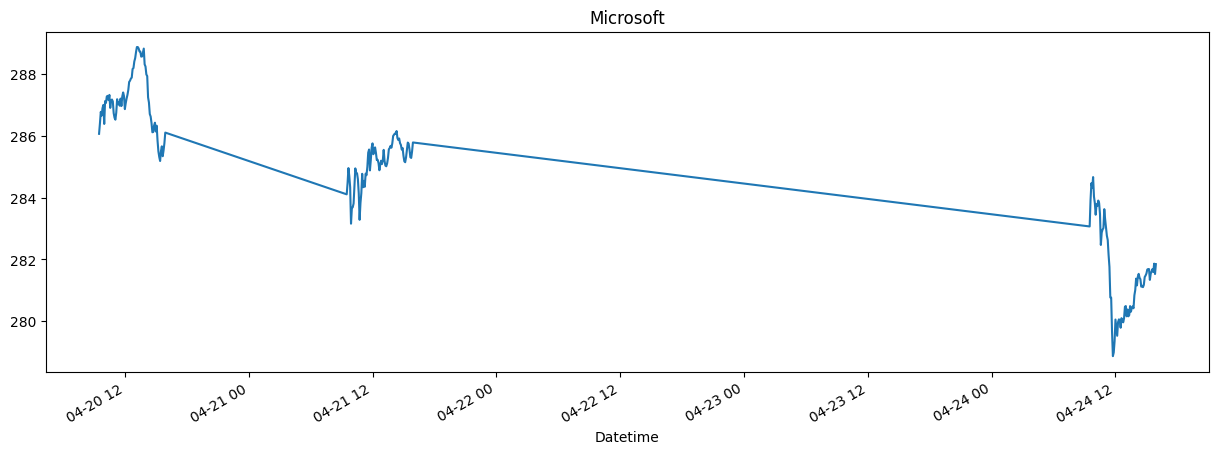

In [167]:
data2['Close'].plot(figsize=(15,5), title='Microsoft')

<AxesSubplot: title={'center': 'Amazon'}, xlabel='date_time'>

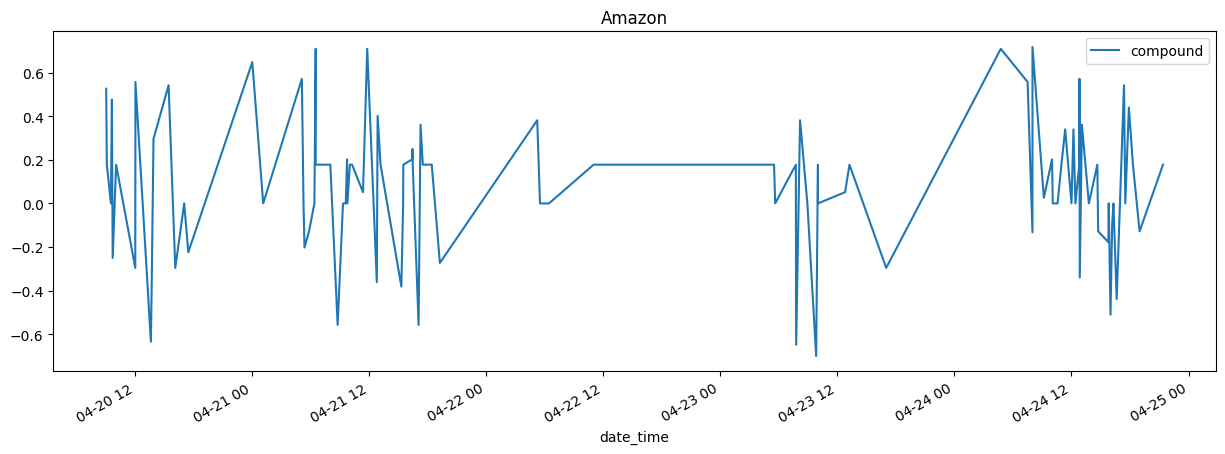

In [173]:
new_df[new_df['Ticker'] == 'AMZN'].plot(x='date_time', y='compound', figsize=(15,5), title='Amazon')

In [ ]:
#example for vader vs roberta

In [175]:
ex = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [176]:
vader.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [180]:
# Run for Roberta Model
# Run for Roberta Model
# Run for Roberta Model
encoded_text = tokenizer(ex, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}
